# Trying out MPE2 simple (base model)

First, let's start with the general framework for running the experiment. The simple environment has only one agent and one landmark. First, let's try a random action.
It should open a window with one moving particle and a "landmark".

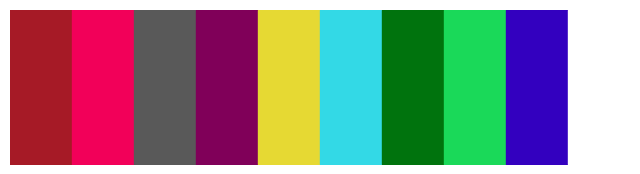

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

colors = [np.array([0.0, 0.0, 0.0]),
          np.array([0.95, 0.0, 0.35]),
          np.array([0.35, 0.35, 0.35]), 
          np.array([0.5, 0.0, 0.35]), 
          np.array([0.9, 0.85, 0.2]),
          np.array([0.2, 0.85, 0.9]),
          np.array([0.0, 0.45, 0.05]),
          np.array([0.1, 0.85, 0.35]),
          np.array([0.2, 0.0, 0.75]),
          np.array([1.0, 1.0, 1.0])]

# Show the colors as patches
plt.figure(figsize=(8, 2))
for i, c in enumerate(colors):
    plt.fill_between([i, i+1], 0, 1, color=c)
plt.xlim(0, len(colors))
plt.ylim(0, 1)
plt.axis('off')
plt.show()

In [2]:
import numpy as np
contact_margin = 1e-3
contact_force = 1e2
dist_min = 0.1
delta_pos = np.array([0.98,0.98]) - np.array([1.0,1.0])
# compute Euclidean distance
dist = np.sqrt(np.sum(np.square(delta_pos)))
penetration = np.logaddexp(0, -(dist - dist_min) / contact_margin) * contact_margin
force = contact_force * delta_pos / dist * penetration
print("dist ", dist)
print("penetration", penetration)
print("force", force)

dist  0.028284271247461926
penetration 0.07171572875253808
force [-5.07106781 -5.07106781]


In [7]:
np.array([1,0]) + np.array([1,-1])

array([ 2, -1])

In [ ]:
# Using the "simple" environment from the multi-agent-particle-envs (mpe2) package as a template
from mpe2 import simple_v3
env = simple_v3.parallel_env(max_cycles=100, render_mode='human')

env.reset() # Do seed=42 for reproducibility
for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample() # this is where you would insert your policy

    env.step(action)
env.close()

/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


We will now use PPO to train the agents. First, we will try with the simple_v3 environment again.

In [3]:
from ray.rllib.algorithms.ppo import PPOConfig
from mpe2 import simple_v3
from ray.tune.registry import register_env
from ray.rllib.env.wrappers.pettingzoo_env import PettingZooEnv
import ray
import particle_v1

ray.init()#ignore_reinit_error=True) # don't re-init if already running
def make_env(env_config=None):
    return particle_v1.parallel_env(max_cycles=25, render_mode=None)

register_env("particle_v1", lambda config: PettingZooEnv(make_env(config)))

# Temporary env instance just to grab one agent's space
tmp_env = PettingZooEnv(make_env())
first_agent = list(tmp_env.observation_space.keys())[0]
obs_space = tmp_env.observation_space[first_agent]
act_space = tmp_env.action_space[first_agent]
tmp_env.close()

config = (
    PPOConfig()
    .environment("particle_v1")
    .training(
        train_batch_size_per_learner=2000,
        lr=0.0004,
    )
    .multi_agent(
        policies={"shared_policy": (None, obs_space, act_space, {})},
        policy_mapping_fn=lambda agent_id, *args, **kwargs: "shared_policy",
    )
)

algo = config.build()
#print(algo.train())

2025-10-08 12:00:32,543	INFO worker.py:1951 -- Started a local Ray instance.
2025-10-08 12:00:34,349	WARNING deprecation.py:50 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
2025-10-08 12:00:34,351	WARNING algorithm_config.py:5045 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed

In [42]:
from ray.tune.logger import pretty_print
for i in range(10):
    result = algo.train()
    print(pretty_print(result))
#algo.stop()
algo.save("/Users/paula/part-sim/ppo_model_checkpoint")

date: 2025-10-08_11-49-56
done: false
env_runner_group:
  actor_manager_num_outstanding_async_reqs: 0
env_runners:
  agent_episode_returns_mean:
    agent_0: -16.77413089470129
    agent_1: -16.424280441626824
    agent_2: -16.46938126045687
    agent_3: -27.307958670859485
    agent_4: -30.092221446710646
    agent_5: -10.026442260182389
    agent_6: -20.60375932543154
    agent_7: -16.28701155006773
    agent_8: -30.907787797650197
    agent_9: -38.806422195142204
  agent_steps:
    agent_0: 25.0
    agent_1: 25.0
    agent_2: 25.0
    agent_3: 25.0
    agent_4: 25.0
    agent_5: 25.0
    agent_6: 25.0
    agent_7: 25.0
    agent_8: 25.0
    agent_9: 25.0
  connector_pipeline_timer: 0.0004748544997710269
  env_reset_timer: 0.0001611045008758083
  env_step_timer: 0.0001164026690279647
  env_to_module_connector:
    connector_pipeline_timer: 6.887857190600966e-05
    timers:
      connectors:
        add_observations_from_episodes_to_batch: 1.4704572538911084e-05
        add_states_fro

TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/Users/paula/part-sim/ppo_model_checkpoint), metrics={'timers': {'training_iteration': 1.7281124494869142, 'restore_env_runners': 4.267214847766261e-05, 'training_step': 1.727817963624737, 'env_runner_sampling_timer': 0.5316941490206534, 'learner_update_timer': 1.1939602224874015, 'synch_weights': 0.0013790063710762176, 'synch_env_connectors': 0.0031060886355445765}, 'env_runners': {'num_agent_steps_sampled': {'agent_9': 208.0, 'agent_6': 208.0, 'agent_3': 208.0, 'agent_4': 208.0, 'agent_2': 208.0, 'agent_5': 208.0, 'agent_0': 200.0, 'agent_7': 208.0, 'agent_1': 208.0, 'agent_8': 208.0}, 'num_episodes_lifetime': 80.0, 'num_episodes': 8.0, 'env_to_module_connector': {'timers': {'connectors': {'add_time_dim_to_batch_and_zero_pad': 2.841692676237993e-06, 'numpy_to_tensor': 1.0443521055121858e-05, 'add_states_from_episodes_to_batch': 2.0731631900984206e-06, 'add_observations_from_episodes_to_batch': 1.4849080504981556e-05, 'agent_

In [10]:
import os
from ray.rllib.core import (
    COMPONENT_ENV_RUNNER,
    COMPONENT_ENV_TO_MODULE_CONNECTOR,
    COMPONENT_MODULE_TO_ENV_CONNECTOR,
    COMPONENT_LEARNER_GROUP,
    COMPONENT_LEARNER,
    COMPONENT_RL_MODULE,
    DEFAULT_MODULE_ID, # this is "default_policy" by default but in multi-agent it is "shared_policy"
)
from ray.rllib.core.rl_module.rl_module import RLModule


# Create RLModule from a checkpoint.
rl_module = RLModule.from_checkpoint(
    os.path.join(
        "/Users/paula/part-sim/ppo_model_checkpoint", # checkpoint.path (or directly a string path to the checkpoint dir)
        COMPONENT_LEARNER_GROUP,
        COMPONENT_LEARNER,
        COMPONENT_RL_MODULE,
        "shared_policy", # DEFAULT_MODULE_ID,
    )
)

In [39]:
# from chat
from ray.rllib.connectors.env_to_module import EnvToModulePipeline
from ray.rllib.connectors.module_to_env import ModuleToEnvPipeline
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.env.single_agent_episode import SingleAgentEpisode
from ray.rllib.core.columns import Columns
import os

# Restore components from the checkpoint
checkpoint_path = "/Users/paula/part-sim/ppo_model_checkpoint"

env_to_module = EnvToModulePipeline.from_checkpoint(
    os.path.join(checkpoint_path, "env_runner", "env_to_module_connector")
)

rl_module = RLModule.from_checkpoint(
    os.path.join(checkpoint_path, "learner_group", "learner", "rl_module", "shared_policy")
)

module_to_env = ModuleToEnvPipeline.from_checkpoint(
    os.path.join(checkpoint_path, "env_runner", "module_to_env_connector")
)

# Set up the environment
from mpe2 import simple_v3
env = simple_v3.env(max_cycles=100, render_mode='human')

# Reset the environment and initialize the episode
# Temporary env instance just to grab one agent's space
tmp_env = PettingZooEnv(env)
first_agent = list(tmp_env.observation_space.keys())[0]
obs_space = tmp_env.observation_space[first_agent]
act_space = tmp_env.action_space[first_agent]
observations1, _ = tmp_env.reset()
obs = observations1[first_agent] # returns global state, which is the same as the observations for the single agent, here
tmp_env.close()

episode = SingleAgentEpisode(
    observations=[obs],
    observation_space=env.observation_space,
    action_space=env.action_space,
)

# Inference loop
num_episodes = 0
max_episodes = 10

while num_episodes < max_episodes:
    shared_data = {}
    input_dict = env_to_module(
        episodes=[episode],
        rl_module=rl_module,
        explore=False,  # Disable exploration for inference
        shared_data=shared_data,
    )

    # Compute actions using the RLModule
    rl_module_out = rl_module.forward_inference(input_dict)

    # Process the RLModule output and send actions to the environment
    to_env = module_to_env(
        batch=rl_module_out,
        episodes=[episode],
        rl_module=rl_module,
        explore=False,
        shared_data=shared_data,
    )
    action = to_env.pop(Columns.ACTIONS)[0]
    obs, reward, terminated, truncated, _ = env.step(action)

    # Update the episode
    episode.add_env_step(
        obs,
        action,
        reward,
        terminated=terminated,
        truncated=truncated,
        extra_model_outputs={k: v[0] for k, v in to_env.items()},
    )

    # Check if the episode is done
    if episode.is_done:
        print(f"Episode done: Total reward = {episode.get_return()}")
        obs, _ = env.reset()
        episode = SingleAgentEpisode(
            observations=[obs],
            observation_space=env.observation_space,
            action_space=env.action_space,
        )
        num_episodes += 1

env.close()
print(f"Completed {num_episodes} episodes of inference.")

TypeError: argument of type 'DefaultPPOTorchRLModule' is not iterable

In [24]:
env.state()

0.0

In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
from mpe2 import simple_v3
from ray.tune.registry import register_env
from ray.rllib.env.wrappers.pettingzoo_env import PettingZooEnv
from supersuit import flatten_v0

def make_env(env_config=None):
    env = simple_v3.parallel_env(max_cycles=25, render_mode=None)  # parallel API is best for RLlib
    return flatten_v0(env)

# Register custom environment with Rllib
register_env("simple_v3", lambda config: PettingZooEnv(make_env(config))) # we also have to use the Pettingzoo wrapper

# Configure.
config = (
    PPOConfig()
    .environment("simple_v3")
    .training(
        train_batch_size_per_learner=2000, # num of steps per agent
        lr=0.0004,
    )
)

# Build the Algorithm.
algo = config.build_algo()

# Train for one iteration, which is 2000 timesteps (1 train batch).
print(algo.train())

# Saves to a folder "ppo_model_checkpoint"
algo.save()

/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: T

IndexError: list index out of range

In [ ]:
# Now, within let's do some inference in simple_v3 and visualize
env = simple_v3.parallel_env(max_cycles=100, render_mode='human')
from ray.rllib.algorithms.ppo import PPO
import os

# This is our trained policy.
trained_policy = algo.get_module("default_policy")
#checkpoint_path = os.path.expanduser("")
#PPOagent = PPO.from_checkpoint(checkpoint_path)

env.reset() # Do seed=42 for reproducibility

for agent in env.agent_iter():
    last_observation, last_reward, last_termination, last_truncation, last_info = env.last()
    print(f"Last observation: {last_observation}")
    print(f"Last reward: {last_reward}")
    print(f"Last termination: {last_termination}")
    print(f"Last truncation: {last_truncation}")
    print(f"Last info: {last_info}")
    if last_termination or last_truncation:
        action = None
    else:
        #action = env.action_space(agent).sample() 
        action = algo.compute_single_action(observation = last_observation, policy_id="default_policy", full_fetch=True)
    env.step(action)
env.close()

Last observation: [ 0.          0.         -0.953831   -0.34676746]
Last reward: 0.0
Last termination: False
Last truncation: False
Last info: {}


AttributeError: 'MultiAgentEnvRunner' object has no attribute 'get_policy'

In [ ]:
algo.compute_single_action(observation = last_observation, prev_reward = last_reward, info = last_info, episodes = , explore = , timestep = , is_training = , policy_id = , clip_actions = True, full_fetch = False, explore_kwargs = None, timestep_kwargs = None, **kwargs)

ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module.DefaultPPOTorchRLModule

# Trying our own multi-agent environment particle_v1

Now, let's try with our own environment particle_v1 that is within this project. We have multiple agents and can also define more food sources (landmarks), which are marked in orange. First, let's use a  random policy again.

In [1]:
import particle_v1
env = particle_v1.env(num_agents=10, num_food_sources=1, flow = 'none', max_cycles=25, render_mode='human')

env.reset() # Do seed=42 for reproducibility
for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample() # this is where you would insert your policy

    env.step(action)
env.close()

/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Now, let's try with PPO.

In [1]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
from ray.tune import run
import particle_v1
from pettingzoo.utils import parallel_to_aec
from supersuit import pettingzoo_env_to_vec_env_v1, concat_vec_envs_v1
import os

# Wrap our custom environment
def make_env(env_config=None):
    env = particle_v1.parallel_env(num_agents=10, num_food_sources=1, flow='none', max_cycles=25, render_mode=None)  # parallel API is best for RLlib
    return env

# Register custom environment with Rllib
register_env("particle_v1", lambda config: PettingZooEnv(make_env(config))) # we also have to use the Pettingzoo wrapper

# Use PPOConfig from RLlib and call our environment
config = (
    PPOConfig()
    .api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)
    .framework("torch")  # Ensure PyTorch framework
    .environment("particle_v1", env_config={"num_agents": 10, "num_food_sources": 1, "flow": 'none', "max_cycles": 25, "render_mode": None})
    .rl_module()  # Use RLModule for neural network configuration
    .multi_agent(
        policies={"shared_policy"},  # Define shared policy
        policy_mapping_fn=lambda aid, *a, **kw: "shared_policy"
    )
    .env_runners(num_env_runners=2)  # Replace RolloutWorker with EnvRunners
)

algo = config.build()
for i in range(10):
    result = algo.train()

/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
2025-10-06 15:36:08,403	WARNING deprecation.py:50 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
/Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/paula/.pyenv/versions/par

KeyboardInterrupt: 

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: fffffffffffffffffeb32aed41911b97fa2b5fdd01000000 Worker ID: 8b462e4d6e0f41525463d5d1e13e882c645d6c3b06bb2360ecdb284a Node ID: 7ea1cf40fc6d0c0466ca488ab0d26efead8253b283ada5315d5125b3 Worker IP address: 127.0.0.1 Worker port: 64053 Worker PID: 29485 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. The process receives a SIGTERM.


(RolloutWorker pid=29492) /Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(RolloutWorker pid=29492)   from pkg_resources import resource_stream, resource_exists


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a6eb1b5efc397222c14788e01000000 Worker ID: 2c382788931680dd0e170e8d023adecd0ae2193797a05f2cd4061998 Node ID: 7ea1cf40fc6d0c0466ca488ab0d26efead8253b283ada5315d5125b3 Worker IP address: 127.0.0.1 Worker port: 64061 Worker PID: 29486 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. The process receives a SIGTERM.


(RolloutWorker pid=29489) /Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(RolloutWorker pid=29489)   from pkg_resources import resource_stream, resource_exists
(SingleAgentEnvRunner pid=29487) /Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(SingleAgentEnvRunner pid=29487)   from pkg_resources import resource_stream, resource_exists
(SingleAgentEnvRunner pid=29487) 2025-10-06 16:34:30,137	WARNING rl_module.py:432 -- Didn't create

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5820ed88c8f77a6fa6c12b0501000000 Worker ID: e860c72c7caf06394455e3d00ac84e28ca13d7d33d875af391d7440f Node ID: 7ea1cf40fc6d0c0466ca488ab0d26efead8253b283ada5315d5125b3 Worker IP address: 127.0.0.1 Worker port: 64095 Worker PID: 29490 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(SingleAgentEnvRunner pid=30269) /Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=30269)   from pkg_resources import resource_stream, resource_exists [repeated 3x across cluster]
(SingleAgentEnvRunner pid=29491) 2025-10-06 16:39:40,652	ERROR algorithm_config.py:1032 -- Your `config.env_to_module_connector` function seems to have a wrong or outdated signature! It should be: `def myfunc(env, spaces, device): ...`, where any of these arguments are optional and may be None. [repeated 2x across cluster]
(SingleAgentEnvRunner pid=29491) `env` is the (vectorized) gym env. [repeated 2x across cluster]
(SingleAgentEnvRunner pid=29491) `spaces` is a dict of structu

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: fffffffffffffffff42829a68ba556fe214d17d801000000 Worker ID: 742de1593b4cd5e29ae63ee76a217f88544b9153c4b5de97e4d82d01 Node ID: 7ea1cf40fc6d0c0466ca488ab0d26efead8253b283ada5315d5125b3 Worker IP address: 127.0.0.1 Worker port: 49292 Worker PID: 30270 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 2x across cluster]


(SingleAgentEnvRunner pid=30278) /Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 2x across cluster]
(SingleAgentEnvRunner pid=30278)   from pkg_resources import resource_stream, resource_exists [repeated 2x across cluster]
(SingleAgentEnvRunner pid=30270) 2025-10-06 16:40:43,703	ERROR algorithm_config.py:1032 -- Your `config.env_to_module_connector` function seems to have a wrong or outdated signature! It should be: `def myfunc(env, spaces, device): ...`, where any of these arguments are optional and may be None. [repeated 2x across cluster]
(SingleAgentEnvRunner pid=30270) `env` is the (vectorized) gym env. [repeated 2x across cluster]
(SingleAgentEnvRunner pid=30270) `spaces` is a dict of structu

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5820ed88c8f77a6fa6c12b0501000000 Worker ID: e235c771c9f189ceb8c285015b2be103c1fab92abe300659f87f4bd1 Node ID: 7ea1cf40fc6d0c0466ca488ab0d26efead8253b283ada5315d5125b3 Worker IP address: 127.0.0.1 Worker port: 49335 Worker PID: 30277 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(SingleAgentEnvRunner pid=30306) /Users/paula/.pyenv/versions/part-sim/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(SingleAgentEnvRunner pid=30306)   from pkg_resources import resource_stream, resource_exists
(SingleAgentEnvRunner pid=30306) 2025-10-06 16:42:51,372	ERROR algorithm_config.py:1032 -- Your `config.env_to_module_connector` function seems to have a wrong or outdated signature! It should be: `def myfunc(env, spaces, device): ...`, where any of these arguments are optional and may be None.
(SingleAgentEnvRunner pid=30306) `env` is the (vectorized) gym env.
(SingleAgentEnvRunner pid=30306) `spaces` is a dict of structure `{'__env__': ([vectorized env obs. space, vectorized env act. space]),'__env_single__': ([env obs. space, env act

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff8c71b5742b77e2baade6b01601000000 Worker ID: 56dbe1b149c4a762b20224c061be095cd5413243cdf746f95819914a Node ID: 7ea1cf40fc6d0c0466ca488ab0d26efead8253b283ada5315d5125b3 Worker IP address: 127.0.0.1 Worker port: 49425 Worker PID: 30309 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


Let's look at the results object

In [ ]:
# Like before, iterate over agents, but now use a trained PPO model to select actions
env = particle_v1.parallel_env(num_agents=10, num_food_sources=1, flow = 'none', max_cycles=25, render_mode='human')
env.reset(seed=42) # Do seed=42 for reproducibility
policy_id = "shared_policy"

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        action, _, _ = algo.compute_single_action(
            observation,
            policy_id=policy_id,
            explore=False   # like SB3 deterministic=True
        )

    env.step(action)
env.close()

2025-10-02 14:34:59,591	WARNING deprecation.py:50 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


AttributeError: 'MultiAgentEnvRunner' object has no attribute 'get_policy'